In [298]:
import math
import random
import numpy

import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

# Input

In [299]:
words = open('names.txt', 'r').read().splitlines()
print(f'{len(words)}')
words[:8]

32033


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

lookup tables

In [300]:
chars = list('abcdefghijklmnopqrstuvwxyz')
stoi_lookup = {c: i+1 for i, c in enumerate(chars)}
stoi_lookup['.'] = 0
itos_lookups = {i: char for char, i in stoi_lookup.items()}

Dataset creation

In [301]:
block_size = 3 # context length
X, Y = [], []
for word in words:
    # print('word: ', word)
    context = [0] * block_size
    seq = word + '.'    # don't forget to add the . add the end

    for char in seq:
        X.append(context)
        # index of the character to be predicted
        y_i = stoi_lookup[char]
        Y.append(y_i)
        # print(''.join(itos_lookups[c] for c in context), '--->', itos_lookups[y_i])
        context = context[1:] + [y_i]

X = torch.tensor(X)
Y = torch.tensor(Y)

### Embeddings lookup table

in [Bengio et al](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf), 17k words were embeeded into 30 dims

we have to embed 27 chars into small dims, lets start with 2 dims embedding for now

In [302]:
# 27 chars emebedded into two dims randomly
dims = 12
C = torch.randn((27, dims))

# now we have to embed the integers in the input X using the above lookup table C
embs = C[X]
embs.shape

torch.Size([228146, 3, 12])

Hidden & Output Layer

- What would be the input to this layer?

    the embedding have the shape [32, 3, 2] which means that we have 32 inputs and for each input so we have three(one for each character) two dims embeddings => 3 * 2 = 6

- What would be the number of neurons, we can try it with different values, lets say 100 for now

### Build the Dataset

-  both BOS and EOS are represented using '.'

- context - characters to be considered for the next prediction
    - what would be context for the first letter? just '.', the number of '.' will depend on the length of the context


- make sure to represent the EOS as well

In [303]:
def build_dataset(words):
    block_size = 3 # context length
    X, Y = [], []
    for word in words:
        # print('word: ', word)
        context = [0] * block_size
        seq = word + '.'    # don't forget to add the . add the end

        for char in seq:
            X.append(context)
            # index of the character to be predicted
            y_i = stoi_lookup[char]
            Y.append(y_i)
            # print(''.join(itos_lookups[c] for c in context), '--->', itos_lookups[y_i])
            context = context[1:] + [y_i]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print("shapes: ", X.shape, Y.shape)
    return X, Y

training(80%), val(10%), test(10%) splits 
 - training set is used for optimizing the params of the model
 - validation set is used for training the hyperparameters(hidden layer size, embedding size etc)
 - evaluating the performance of the model

In [304]:
random.seed(42)
random.shuffle(words)

train_size = int(0.8*len(words))
val_size = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:train_size])
X_val, Y_val = build_dataset(words[train_size:val_size])
X_test, Y_test = build_dataset(words[val_size:])

shapes:  torch.Size([182625, 3]) torch.Size([182625])
shapes:  torch.Size([22655, 3]) torch.Size([22655])
shapes:  torch.Size([22866, 3]) torch.Size([22866])


### Build the Network

In [305]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 12), generator=g)
W1 = torch.randn((36, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)

params = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in params))

# set the p.grad requires to true first so that we are able to get the grad for the params
for p in params:
    p.requires_grad = True

13151


### Train the Network

In [306]:
batch_size = 32

ix = torch.randint(0, X_train.shape[0], (batch_size, ))

steps = []
losses = []

In [307]:
# training

for step in range(300000):
    # forward pass
    ix = torch.randint(0, X_train.shape[0], (batch_size, ))
    # make sure to only select the indices in the current mini batch
    embs = C[X_train[ix]]
    h = torch.tanh(embs.view(-1, 3*dims) @ W1 + b1)
    logits = h @ W2 + b2
    # only select the indices in the current mini batch
    loss = F.cross_entropy(logits, Y_train[ix])
    # print(f'{loss=}')
    
    # backward pass
    # set the gradients to 0 - IMP
    for p in params:
        p.grad = None
    
    # calculate the gradients of the loss w.r.t params
    loss.backward()

    if step < 100000:
        l_rate = 0.1
    elif 100000 <= step < 200000:
        l_rate = 0.01
    else:
        l_rate = 0.001
    
    # l_rate = 0.1 if step < 100000 else 0.01 # learning rate 
    
    # update the params
    for p in params:
        p.data += -l_rate * p.grad

    steps.append(step)
    losses.append(loss.log10().item())
# print(f'{loss=}')

Plot losses per step

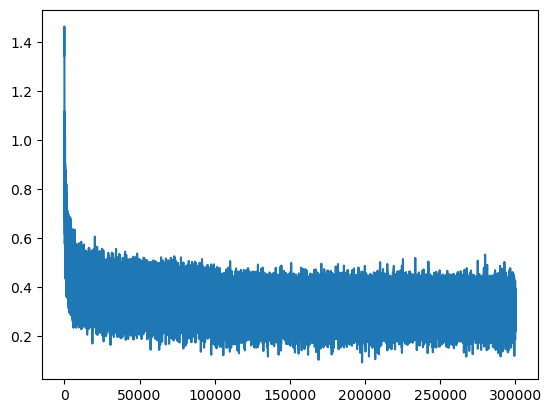

In [308]:
plt.plot(steps, losses)

Calculate the training and validation losses

In [309]:
# training loss
embs = C[X_train]
h = torch.tanh(embs.view(-1, 3*dims) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_train)
loss

tensor(2.0910, grad_fn=<NllLossBackward0>)

In [310]:
# validation loss
embs = C[X_val]
h = torch.tanh(embs.view(-1, 3*dims) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_val)
loss

tensor(2.1469, grad_fn=<NllLossBackward0>)

Sampling from the model

In [311]:
block_size = 3
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(10):
    out = []
    context = [0] * block_size

    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        prob = F.softmax(logits, dim=1)
        ix = torch.multinomial(prob, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos_lookups[i] for i in out))

carmahza.
jahmarik.
mili.
taty.
skanden.
jazhubhaquesric.
kaeli.
nellana.
chaiiv.
kaleigh.


Note 1: 

try to change the hyperparameters such a hidden layer size by trying different variations, if that doesnt affect the loss value greatly then try to found out why the loss value isnt going down by analysing the layers